# Multi-layer Perceptron (with Embeddings)

This notebook is an example of a multi-layer perceptron with Keras (https://keras.io/)

In [1]:
# Import some needed packages
import random
random.seed(2019)
import matplotlib.pyplot as plt
%matplotlib notebook
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

Using TensorFlow backend.


## Load data

We are going to load the tweets from SemEval 2018...

In [2]:
import pandas as pd
import glob

fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*train-*.tsv'
filenames = [filename for filename in sorted(glob.glob(fpattern))]
# print(filenames)


In [3]:
# Load all files into a big data frame...
column_names = ['id', 'tag', 'tweet']
df = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in filenames], ignore_index=True, sort=True)
# df.info()
# df.head()

In [4]:
# Drop rows having 'Not Available'...
df = df[df.tweet != 'Not Available']
# df.info()
# df.head()

## A function to convert a tweet into a set of words

In [5]:
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# turn a document into a list of clean tokens
def clean_doc(doc):
    # Remove links...
    doc = re.sub("\w+:\/\/\S+", " ", doc)
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/petasis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Process all tweets, and save results in the dataframe...

In [6]:
import numpy as np

df['tokens'] = np.array([ clean_doc(tweet) for tweet in df.tweet ])
# df.info()  
# df.head()

## Perform all actions also for dev/test data...

In [7]:
fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*dev-*.tsv'
devfs    = [filename for filename in sorted(glob.glob(fpattern))]
fpattern = '../Exercise_2-TwitterSentimentAnalysis/data/twitter-20*test-*.tsv'
testfs   = [filename for filename in sorted(glob.glob(fpattern))]
df_dev   = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in devfs],  ignore_index=True, sort=True)
df_test  = pd.concat([pd.read_csv(f, sep="\t", quoting=3, names=column_names) for f in testfs], ignore_index=True, sort=True)
df_dev   = df_dev[df_dev.tweet != 'Not Available']
df_test  = df_test[df_test.tweet != 'Not Available']
df_dev['tokens']  = np.array([ clean_doc(tweet) for tweet in df_dev.tweet ])
df_test['tokens'] = np.array([ clean_doc(tweet) for tweet in df_test.tweet ])

## Extract our vocabulary...

In [8]:
from collections import Counter
import itertools

vocabulary = Counter()
for tweet_tokens in itertools.chain(df.tokens, df_dev.tokens, df_test.tokens):
    vocabulary.update(tweet_tokens)

print('Total tweets: ', sum(1 for _ in itertools.chain(df.tokens, df_dev.tokens, df_test.tokens)))
# vocabulary.most_common(10)

Total tweets:  30790


## Filter words using the vocabulary...

In [9]:
def token_to_vector_words(tokens, vocabulary):
    tokens = [w for w in tokens if w in vocabulary]
    return ' '.join(tokens)

# print(df.tweet[0])
# token_to_vector_words(df.tokens[0], vocabulary)

In [10]:
df['vector_tokens']      = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df.tokens ])
df_dev['vector_tokens']  = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df_dev.tokens ])
df_test['vector_tokens'] = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in df_test.tokens ])
# df.info()
# df.head()

In [11]:
# Map tag from class (positive, negative) to numbers...
df['btag']      = df.tag.astype('category').cat.codes
df_dev['btag']  = df_dev.tag.astype('category').cat.codes
df_test['btag'] = df_test.tag.astype('category').cat.codes
# df_dev.head(6)

## Using pre-trained embeddings...

Pre-trained embeddings can be found:

GloVe: http://nlp.stanford.edu/projects/glove/

Word2Vec: https://code.google.com/archive/p/word2vec/

In [12]:
# Load embeddings into a dict...
embedding_dimension = 50
embeddings_index = {}
glove_data = '../data/embeddings/glove.twitter.27B.'+str(embedding_dimension)+'d.txt'
f = open(glove_data)
for line in f:
    values = line.split()
    word = values[0]
    value = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = value
f.close()
 
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


## Lets make our vectors...

In [13]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.vector_tokens)

word_index = tokenizer.word_index

# The embedding_matrix matrix maps words to vectors in the specified embedding dimension:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimension))
for word, i in word_index.items():
    # print(word, i) <= i starts from 1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector;#[:embedding_dimension]
print(embedding_matrix.shape)
print(embedding_matrix)

Xtrain = tokenizer.texts_to_sequences(df.vector_tokens)
Ytrain = df.btag
Xtest  = tokenizer.texts_to_sequences(df_test.vector_tokens)
Ytest  = df_test.btag
from keras.utils import to_categorical
Ytrain_one_hot = to_categorical(Ytrain)
Ytest_one_hot  = to_categorical(Ytest)
print(Xtrain[0])

## Get the longest tweet...
longest = max(df.tokens,key=len)
print(longest)
longest = max(Xtrain,key=len)
print(longest)
longest = len(longest)
print("Longest tweet (in words): ", longest)

(23740, 50)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.51880002  0.039331    0.080883   ... -0.81913    -0.28933999
   0.87558001]
 [ 0.43026     0.0081207  -0.0090224  ... -0.24276    -0.51657999
   1.24720001]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.086368    1.26409996  0.18991999 ... -0.43009001 -0.30998001
   0.047121  ]
 [-1.40139997  1.06110001 -0.14475    ... -0.16698    -0.26725999
  -0.70081002]]
[2625, 141, 358, 7, 6, 2340, 1249, 49]
['Make', 'Sure', 'To', 'Come', 'To', 'The', 'Bob', 'Jones', 'Game', 'Friday', 'Free', 'Hot', 'Dogs', 'Hamburgers', 'amp', 'Food', 'outside', 'gate', 'amp', 'watch', 'Bob', 'Jones', 'take', 'Austin', 'High']
[34, 119, 327, 29, 327, 5, 192, 1542, 15, 10, 96, 470, 1564, 14202, 11, 635, 1020, 3845, 11, 24, 192, 1542, 85, 1321, 465]
Longest tweet (in words):  25


### We need to set the length of all tweets to the longest tweet...

In [14]:
from keras.preprocessing.sequence import pad_sequences
print(Xtrain[0])
Xtrain = pad_sequences(Xtrain, maxlen=longest)
Xtest  = pad_sequences(Xtest,  maxlen=longest)
print(Xtrain[0])

[2625, 141, 358, 7, 6, 2340, 1249, 49]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 2625  141  358    7    6 2340 1249   49]


## A simple MLP model...

In [15]:
n_words = embedding_matrix.shape[0]
print(n_words)

23740


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 50)            1187000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3753      
Total params: 1,190,753
Trainable params: 3,753
Non-trainable params: 1,187,000
_________________________________________________________________


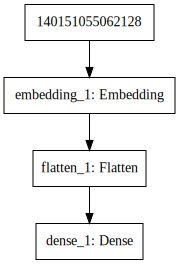

In [16]:
from keras.utils.vis_utils import plot_model
from keras.layers import Flatten
from keras.layers import Embedding

# define network
model = Sequential()
#model.add(Dense(units=64, activation='relu', input_shape=(n_words,)))
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
    weights=[embedding_matrix], input_length=longest, trainable=False))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))
# compile network
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
# summarize defined model
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Fit our network...

In [17]:
# fit network
from keras import backend as K
model.fit(K.cast_to_floatx(Xtrain), K.cast_to_floatx(Ytrain_one_hot), batch_size=128, epochs=120, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/120
 - 0s - loss: 0.2216 - acc: 0.4331
Epoch 2/120
 - 0s - loss: 0.2114 - acc: 0.4604
Epoch 3/120
 - 0s - loss: 0.2057 - acc: 0.4830
Epoch 4/120
 - 0s - loss: 0.2016 - acc: 0.4985
Epoch 5/120
 - 0s - loss: 0.1983 - acc: 0.5128
Epoch 6/120
 - 0s - loss: 0.1958 - acc: 0.5236
Epoch 7/120
 - 0s - loss: 0.1935 - acc: 0.5328
Epoch 8/120
 - 0s - loss: 0.1917 - acc: 0.5384
Epoch 9/120
 - 0s - loss: 0.1901 - acc: 0.5450
Epoch 10/120
 - 0s - loss: 0.1886 - acc: 0.5478
Epoch 11/120
 - 0s - loss: 0.1873 - acc: 0.5540
Epoch 12/120
 - 0s - loss: 0.1860 - acc: 0.5584
Epoch 13/120
 - 0s - loss: 0.1849 - acc: 0.5613
Epoch 14/120
 - 0s - loss: 0.1838 - acc: 0.5645
Epoch 15/120
 - 0s - loss: 0.1828 - acc: 0.5662
Epoch 16/120
 - 0s - loss: 0.1819 - acc: 0.5701
Epoch 17/120
 - 0s - loss: 0.1810 - acc: 0.5723
Epoch 18/120
 - 0s - loss: 0.1802 - acc: 0.5730
Epoch 19/120
 - 0s - loss: 0.1794 - acc: 0.5770
Epoch 20/120
 - 0s - loss: 0.1787 - acc: 0.5791
E

## Evaluate our fit network...


In [18]:
# evaluate
loss, acc = model.evaluate(K.cast_to_floatx(Xtest), K.cast_to_floatx(Ytest_one_hot), verbose=2)
print('Test Accuracy: %f' % (acc*100))

Y_hat = model.predict(K.cast_to_floatx(Xtest))
Y_hat_int = np.argmax(Y_hat, axis=1)
Y_int = np.argmax(Ytest_one_hot, axis=1)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

d = dict(enumerate(df_test.tag.astype('category').cat.categories))
target_names = list(d.values())
print(target_names)
print(confusion_matrix(Y_int, Y_hat_int))
print(classification_report(Y_int, Y_hat_int, digits=4, target_names=target_names))
print(accuracy_score(Y_int, Y_hat_int))

Test Accuracy: 56.649044
['negative', 'neutral', 'positive']
[[ 750 1080  726]
 [ 665 4542 3171]
 [ 175 1645 4459]]
              precision    recall  f1-score   support

    negative     0.4717    0.2934    0.3618      2556
     neutral     0.6250    0.5421    0.5806      8378
    positive     0.5336    0.7101    0.6094      6279

   micro avg     0.5665    0.5665    0.5665     17213
   macro avg     0.5434    0.5152    0.5173     17213
weighted avg     0.5689    0.5665    0.5586     17213

0.5664904432696218


## Add one more layer...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 50)            1187000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 1250)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3753      
Total params: 1,190,753
Trainable params: 1,190,753
Non-trainable params: 0
_________________________________________________________________


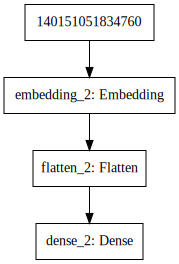

In [19]:
from keras.utils.vis_utils import plot_model
from keras.layers import Flatten
from keras.layers import Embedding
from keras import optimizers

# define network
model = Sequential()
#model.add(Dense(units=64, activation='relu', input_shape=(n_words,)))
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
    weights=[embedding_matrix], input_length=longest, trainable=True))
model.add(Flatten())
#model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
# compile network
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# summarize defined model
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [20]:
# fit network
model.fit(K.cast_to_floatx(Xtrain), K.cast_to_floatx(Ytrain_one_hot), batch_size=1024, epochs=40, verbose=2)

Epoch 1/40
 - 0s - loss: 1.1076 - acc: 0.4273
Epoch 2/40
 - 0s - loss: 0.9777 - acc: 0.5062
Epoch 3/40
 - 0s - loss: 0.9198 - acc: 0.5482
Epoch 4/40
 - 0s - loss: 0.8871 - acc: 0.5718
Epoch 5/40
 - 0s - loss: 0.8665 - acc: 0.5850
Epoch 6/40
 - 0s - loss: 0.8529 - acc: 0.5917
Epoch 7/40
 - 0s - loss: 0.8414 - acc: 0.6000
Epoch 8/40
 - 0s - loss: 0.8335 - acc: 0.6066
Epoch 9/40
 - 0s - loss: 0.8252 - acc: 0.6114
Epoch 10/40
 - 0s - loss: 0.8193 - acc: 0.6134
Epoch 11/40
 - 0s - loss: 0.8142 - acc: 0.6148
Epoch 12/40
 - 0s - loss: 0.8096 - acc: 0.6195
Epoch 13/40
 - 0s - loss: 0.8057 - acc: 0.6217
Epoch 14/40
 - 0s - loss: 0.8021 - acc: 0.6213
Epoch 15/40
 - 0s - loss: 0.7989 - acc: 0.6208
Epoch 16/40
 - 0s - loss: 0.7960 - acc: 0.6226
Epoch 17/40
 - 0s - loss: 0.7938 - acc: 0.6248
Epoch 18/40
 - 0s - loss: 0.7915 - acc: 0.6282
Epoch 19/40
 - 0s - loss: 0.7893 - acc: 0.6287
Epoch 20/40
 - 0s - loss: 0.7870 - acc: 0.6282
Epoch 21/40
 - 0s - loss: 0.7844 - acc: 0.6322
Epoch 22/40
 - 0s - lo

In [21]:
# evaluate
loss, acc = model.evaluate(K.cast_to_floatx(Xtest), K.cast_to_floatx(Ytest_one_hot), verbose=2)
print('Test Accuracy: %f' % (acc*100))

Y_hat = model.predict(K.cast_to_floatx(Xtest))
Y_hat_int = np.argmax(Y_hat, axis=1)
Y_int = np.argmax(Ytest_one_hot, axis=1)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
print(confusion_matrix(Y_int, Y_hat_int))
print(classification_report(Y_int, Y_hat_int, digits=4, target_names=target_names))
print(accuracy_score(Y_int, Y_hat_int))

Test Accuracy: 57.787719
[[ 765 1232  559]
 [ 676 5128 2574]
 [ 200 2025 4054]]
              precision    recall  f1-score   support

    negative     0.4662    0.2993    0.3645      2556
     neutral     0.6116    0.6121    0.6118      8378
    positive     0.5641    0.6456    0.6021      6279

   micro avg     0.5779    0.5779    0.5779     17213
   macro avg     0.5473    0.5190    0.5262     17213
weighted avg     0.5727    0.5779    0.5716     17213

0.5778771858479057
